In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import random
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [2]:
X = [[0, 0], [1, 1]]
y = [0, 1]

modelo = SVC()
modelo.fit(X,y)

SVC()

In [3]:
modelo.predict([[0,0],[1,0],[0,1],[1,1],[0.49,0.49]])

array([0, 1, 1, 1, 0])

In [4]:
# Descobrir caminhos de imagens e classificação
images_path = '../dataset_converted'

# loaded variables
df = pd.DataFrame(columns=['path','classification'])
classification_label = []

for f_number, folder in enumerate(os.listdir(images_path)):
    folder_path = os.path.join(images_path, folder)
    classification_label.append(folder)
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1] = [image_path, f_number]

classification_label, df

(['ASC-H',
  'ASC-US',
  'HSIL',
  'LSIL',
  'Negative for intraepithelial lesion',
  'SCC'],
                                       path  classification
 0     ../dataset_converted/ASC-H/11470.png               0
 1     ../dataset_converted/ASC-H/11471.png               0
 2     ../dataset_converted/ASC-H/11472.png               0
 3      ../dataset_converted/ASC-H/7716.png               0
 4      ../dataset_converted/ASC-H/7717.png               0
 ...                                    ...             ...
 5576     ../dataset_converted/SCC/8057.png               5
 5577     ../dataset_converted/SCC/8058.png               5
 5578     ../dataset_converted/SCC/8126.png               5
 5579     ../dataset_converted/SCC/8127.png               5
 5580     ../dataset_converted/SCC/8128.png               5
 
 [5581 rows x 2 columns])

In [5]:
# Carregar as imagens e fazer pré-processamento
def preprocess_image(image_path):
   # Carregar a imagem em escala de cinza
   image = np.array(Image.open(image_path).convert('L'))
   # Aplicar equalização de histograma
   # image = cv2.equalizeHist(image)
   return image.ravel()

In [6]:
# Plotar a imagem original e a equalizada
def plot_images(equalized):
    plt.figure(figsize=(10, 5))
    # Mostrar imagem equalizada
    plt.subplot()
    plt.title("Equalized Image")
    plt.imshow(equalized, cmap='gray')
    plt.axis('off')
    plt.show()

In [7]:
# Pré-processar a imagem
equalized_image = preprocess_image(df['path'][100])

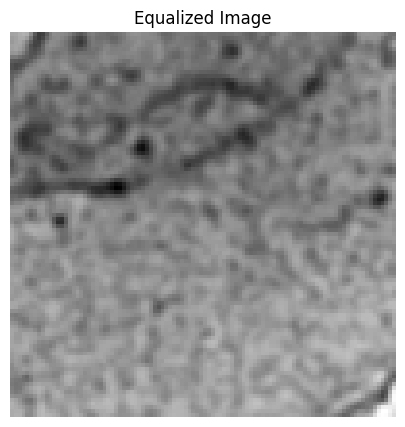

In [8]:
# Plotar as imagens
plot_images(equalized_image.reshape(100,100))

In [9]:
df['image'] = df['path'].apply(preprocess_image)
df

,path,classification,image
0,../dataset_converted/ASC-H/11470.png,0,"[112, 120, 122, 128, 134, 128, 129, 133, 134, ..."
1,../dataset_converted/ASC-H/11471.png,0,"[135, 135, 134, 139, 148, 144, 137, 135, 136, ..."
2,../dataset_converted/ASC-H/11472.png,0,"[156, 165, 170, 176, 180, 181, 157, 151, 158, ..."
3,../dataset_converted/ASC-H/7716.png,0,"[142, 138, 123, 104, 96, 98, 102, 108, 106, 10..."
4,../dataset_converted/ASC-H/7717.png,0,"[30, 41, 72, 123, 159, 167, 150, 133, 139, 146..."
...,...,...,...
5576,../dataset_converted/SCC/8057.png,5,"[37, 32, 22, 18, 17, 16, 17, 19, 20, 20, 19, 1..."
5577,../dataset_converted/SCC/8058.png,5,"[136, 146, 154, 157, 148, 148, 164, 161, 149, ..."
5578,../dataset_converted/SCC/8126.png,5,"[38, 39, 37, 31, 24, 22, 28, 35, 43, 54, 63, 7..."
5579,../dataset_converted/SCC/8127.png,5,"[98, 73, 46, 34, 27, 22, 16, 14, 14, 11, 10, 1..."


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['classification'], test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)

X_train = np.vstack(X_train.values)
y_train = y_train.values
X_test = np.vstack(X_test.values)
y_test = y_test.values

df_train, X_test, y_test, len(X_test), len(y_test)

(                                                  image  classification
 4957  [69, 69, 64, 58, 56, 56, 57, 55, 54, 51, 48, 5...               4
 1860  [72, 63, 60, 61, 66, 71, 79, 89, 102, 109, 113...               4
 3100  [89, 87, 88, 88, 90, 93, 94, 92, 91, 93, 99, 1...               4
 1988  [107, 108, 111, 123, 134, 134, 128, 118, 111, ...               4
 4041  [191, 190, 191, 191, 192, 195, 193, 193, 193, ...               4
 ...                                                 ...             ...
 3772  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...               4
 5191  [46, 48, 50, 51, 54, 56, 57, 59, 60, 60, 64, 7...               4
 5226  [182, 182, 177, 169, 162, 153, 156, 168, 169, ...               4
 5390  [158, 175, 181, 186, 172, 149, 152, 160, 167, ...               4
 860   [184, 181, 168, 162, 164, 169, 180, 178, 170, ...               3
 
 [4464 rows x 2 columns],
 array([[197, 202, 214, ..., 227, 224, 228],
        [176, 176, 179, ..., 201, 201, 200],
      

In [11]:
class_counts = df_train['classification'].value_counts()
min_class_count = class_counts.min()
class_counts, min_class_count

(classification
 4    3413
 3     392
 1     297
 2     227
 5      70
 0      65
 Name: count, dtype: int64,
 65)

# Treinar o modelo SVC

In [32]:
modelo = SVC(max_iter=500,tol=0.000001)

In [13]:
def train_model(model, df_train, iter_p_roll=100, max_iter=1000, class_col='classification', obj_col='image'):
    class_counts = df_train['classification'].value_counts()
    min_class_count = class_counts.min()
    
    modelo.max_iter = iter_p_roll
    n_epoch = max_iter//iter_p_roll
    
    for _ in range(n_epoch):
        balanced_df = pd.concat([
            df_train[df_train['classification'] == cls].sample(min_class_count)
            for cls in range(len(class_counts))
        ])
        balanced_df['tmp'] = balanced_df.apply(lambda x: random.random(), axis=1)
        balanced_df = balanced_df.sort_values('tmp')
        balanced_df = balanced_df.drop('tmp', axis=1)
    
        X = np.vstack(balanced_df['image'].values)
        y = balanced_df['classification'].values
        X,y
        
        model.fit(X,y)

In [33]:
train_model(modelo, df_train, iter_p_roll=500, max_iter=20000)

In [34]:
modelo.fit(X_train, y_train)

/home/kosta/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(max_iter=500, tol=1e-06)

In [35]:
modelo.score(X_test, y_test)

0.7439570277529096

In [27]:
df['predict'] = df['image'].apply(lambda x: modelo.predict([x])[0])
correct = df.apply(lambda x: x['classification'] == x['predict'], axis=1)
df[correct]

,path,classification,image,predict
487,../dataset_converted/HSIL/7606.png,2,"[29, 28, 32, 45, 76, 105, 119, 138, 162, 177, ...",2
488,../dataset_converted/HSIL/7607.png,2,"[18, 20, 31, 47, 74, 101, 126, 140, 141, 135, ...",2
493,../dataset_converted/HSIL/7665.png,2,"[58, 49, 44, 40, 36, 33, 33, 39, 50, 64, 72, 7...",2
496,../dataset_converted/HSIL/7668.png,2,"[137, 137, 134, 136, 147, 162, 169, 169, 153, ...",2
503,../dataset_converted/HSIL/7700.png,2,"[51, 58, 68, 77, 86, 97, 105, 107, 100, 98, 10...",2
...,...,...,...,...
5497,../dataset_converted/Negative for intraepithel...,4,"[71, 66, 59, 61, 71, 81, 91, 87, 82, 57, 44, 3...",4
5498,../dataset_converted/Negative for intraepithel...,4,"[88, 89, 97, 92, 82, 77, 71, 67, 67, 87, 103, ...",4
5501,../dataset_converted/SCC/7600.png,5,"[28, 29, 29, 33, 36, 39, 44, 50, 54, 59, 63, 6...",5
5518,../dataset_converted/SCC/7730.png,5,"[100, 112, 116, 113, 116, 112, 115, 136, 144, ...",5


In [31]:
import joblib
joblib.dump(modelo, 'modelo_svc.pkl')

['modelo_svc.pkl']

In [37]:
modelo_carregado = joblib.load('modelo_svc.pkl')
modelo_carregado.score(X_test, y_test)

0.7439570277529096

In [ ]:
df['predict'] = df['image'].apply(lambda x: modelo_carregado.predict([x])[0])
correct = df.apply(lambda x: x['classification'] == x['predict'], axis=1)
df[correct]